In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
print("Samples", words[:8])   
print("Size", len(words))
print("Largest", max(len(w) for w in words))



Samples ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Size 32033
Largest 15


In [3]:
chars = sorted (list(set (''. join(words))))

stoi = {s: i+1  for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i  in stoi.items()}

vocab_size = len(itos)

print(itos)
print(stoi)
print("Training vocabulary size", vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
Training vocabulary size 27


In [4]:
block_size = 3  #buildinig blocks of 3 characters

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            
            ix = stoi[ch]
            
            X.append(context)
            Y.append(stoi[ch])
        
            context = context[1:] + [stoi[ch]]
            
    X = torch.tensor(X) 
    Y = torch.tensor(Y)
    
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)

random.shuffle(words)
n1 = int (0.8 * len(words))  
n2 = int (0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:

def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact : {str(ex):5s} | approx : {str(app):5s} | maxdiff : {maxdiff}')


In [6]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator = g)

#Layer1
W1 = torch.randn((block_size * n_embd, n_hidden), generator = g) 
W1 *= (5/3) /(n_embd * block_size) ** 0.5
b1 = torch.randn(n_hidden , generator = g)

#batch-normalization
bngain = torch.randn(1, n_hidden) * 0.1  + 1.0
bnbias = torch.randn(1, n_hidden ) * 0.1


#Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.1
b2 = torch.randn(vocab_size, generator = g) * 0.1

parameters = [C, W1, b1, bngain, bnbias, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True
    

4137


In [7]:
batch_size = 32 #batch construction from the training set
n = batch_size 

ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [8]:
#Forward Pass

emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

hprebn = embcat @ W1 + b1

bnmeani = 1/n * hprebn.sum(0, keepdim = True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1/ (n-1) * (bndiff2).sum(0, keepdim = True)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff  *  bnvar_inv
hpreact = bngain * bnraw + bnbias

h = torch.tanh(hpreact)

logits = h @ W2 + b2

logit_maxes = logits.max(1, keepdim = True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim = True)
counts_sum_inv = counts_sum ** -1

probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

for p in parameters:
    p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, 
        logit_maxes, logits, h, hpreact, bnraw, bnvar_inv,
        bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    
    t.retain_grad()
    
loss.backward()
loss


tensor(3.3577, grad_fn=<NegBackward0>)

Backpropagation

In [9]:
#logprobs

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / n
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact : True  | approx : True  | maxdiff : 0.0


In [10]:
#probs

dprobs = (1 / probs ) * dlogprobs 
cmp('probs', dprobs, probs)


probs           | exact : True  | approx : True  | maxdiff : 0.0


In [11]:
#counts_sum_inv

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim = True)
cmp ("Counts_sum_inv", dcounts_sum_inv, counts_sum_inv)

Counts_sum_inv  | exact : True  | approx : True  | maxdiff : 0.0


In [12]:
#counts

dcounts = counts_sum_inv * dprobs

cmp('counts', dcounts, counts) #false

counts          | exact : False | approx : False | maxdiff : 0.006144948769360781


In [13]:
#Counts_sum

dcounts_sum =  - counts_sum ** (-2) * dcounts_sum_inv
cmp ('counts_sum', dcounts_sum, counts_sum)


counts_sum      | exact : True  | approx : True  | maxdiff : 0.0


In [14]:
#dcounts

dcounts += torch.ones_like(counts) * dcounts_sum

cmp('counts', dcounts, counts)


counts          | exact : True  | approx : True  | maxdiff : 0.0


In [15]:
dnorm_logits = counts * dcounts

cmp('norm_logits', dnorm_logits, norm_logits)

norm_logits     | exact : True  | approx : True  | maxdiff : 0.0


In [16]:
dlogits = dnorm_logits.clone()
dlogit_maxes = -1 * dnorm_logits.sum(1, keepdim = True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact : True  | approx : True  | maxdiff : 0.0


In [17]:
dlogits += F.one_hot(logits.max(1).indices, num_classes = logits.shape[1]) * dlogit_maxes

cmp('logits', dlogits, logits)

logits          | exact : True  | approx : True  | maxdiff : 0.0


In [18]:
dh = dlogits @ W2.T
cmp('h', dh, h)

dW2 = h.T @ dlogits
cmp('W2', dW2, W2)

db2 = dlogits.sum(0)
cmp('b2', db2, b2)

h               | exact : True  | approx : True  | maxdiff : 0.0
W2              | exact : True  | approx : True  | maxdiff : 0.0
b2              | exact : True  | approx : True  | maxdiff : 0.0


In [19]:
dhpreact = (1.0 - h ** 2) * dh
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact : True  | approx : True  | maxdiff : 0.0


In [20]:
#batch norms

dbngain = (bnraw * dhpreact).sum(0,keepdim = True)
cmp('bngain', dbngain, bngain)

bngain          | exact : True  | approx : True  | maxdiff : 0.0


In [21]:
dbnraw = bngain * dhpreact
cmp('bnraw', dbnraw, bnraw)

bnraw           | exact : True  | approx : True  | maxdiff : 0.0


In [22]:
dbnbias = dhpreact.sum(0, keepdim = True)
cmp('bnbias', dbnbias, bnbias) 

bnbias          | exact : True  | approx : True  | maxdiff : 0.0


In [23]:
dbnvar_inv = (bndiff * dbnraw ).sum(0, keepdim = True)
cmp("bnvar_inv", dbnvar_inv, bnvar_inv)

bnvar_inv       | exact : True  | approx : True  | maxdiff : 0.0


In [24]:
#bndiff 

dbndiff = bnvar_inv * dbnraw
cmp('bndiff', dbndiff, bndiff) #false

bndiff          | exact : False | approx : False | maxdiff : 0.0011120662093162537


In [25]:
dbnvar = (-0.5 * (bnvar + 1e-5)  ** (-1.5) )* dbnvar_inv
cmp('bnvar' ,dbnvar, bnvar) 


bnvar           | exact : True  | approx : True  | maxdiff : 0.0


Bressel Correction


In [26]:
dbndiff2 = (1.0 / (n-1)) * torch.ones_like(bndiff2) * dbnvar
cmp('bndiff2', dbndiff2, bndiff2)



bndiff2         | exact : True  | approx : True  | maxdiff : 0.0


In [27]:
dbndiff += 2 * bndiff * dbndiff2
cmp('bndiff', dbndiff, bndiff)

bndiff          | exact : True  | approx : True  | maxdiff : 0.0


In [28]:
bndiff.size(), dbndiff.size()

(torch.Size([32, 64]), torch.Size([32, 64]))

In [29]:
dbnmeani = (-1.0) * dbndiff.sum(0, keepdim = True)
cmp('bnmeani', dbnmeani, bnmeani)

bnmeani         | exact : True  | approx : True  | maxdiff : 0.0


In [30]:
dhprebn = dbndiff.clone() 
cmp('hprebn', dhprebn, hprebn) #false

hprebn          | exact : False | approx : False | maxdiff : 0.0009040288859978318


In [31]:
dhprebn += (1.0 / n) * torch.ones_like(hprebn) * dbnmeani
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact : True  | approx : True  | maxdiff : 0.0


In [33]:
dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

embcat          | exact : True  | approx : True  | maxdiff : 0.0


In [35]:
dW1 = embcat.T @ dhprebn
cmp('W1', dW1, W1)

W1              | exact : True  | approx : True  | maxdiff : 0.0


In [36]:
db1 = dhprebn.sum(0)
cmp('b1', db1, b1)

b1              | exact : True  | approx : True  | maxdiff : 0.0


In [38]:
demb = dembcat.view(n, -1, emb.shape[2])
cmp('emb', demb, emb)

emb             | exact : True  | approx : True  | maxdiff : 0.0


In [50]:

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]        
        dC[ix] += demb[k, j] 

cmp('C', dC, C)

C               | exact : True  | approx : True  | maxdiff : 0.0


In [51]:
Xb.shape

torch.Size([32, 3])

Loss Simplification

In [55]:
#forward pass

loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.357696533203125 diff: -2.384185791015625e-07


In [59]:
#backward pass

dlogits = F.softmax(logits, dim = 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)


logits          | exact : False | approx : True  | maxdiff : 7.2177499532699585e-09


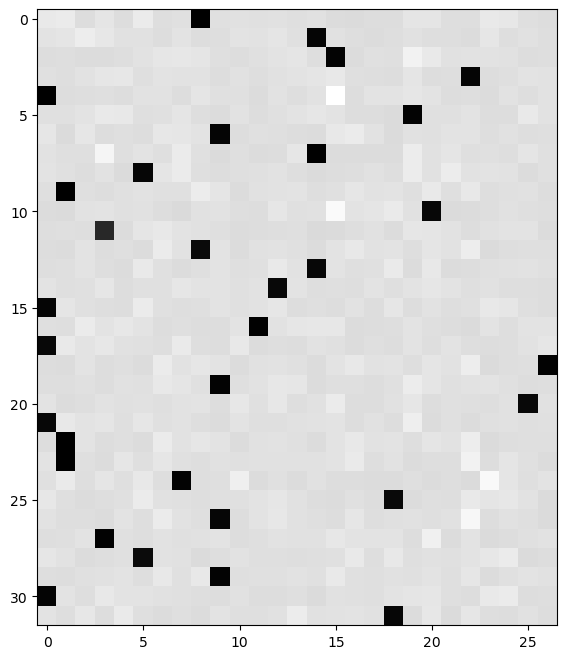

In [60]:
plt.figure(figsize = (8,8 ))

plt.imshow(dlogits.detach(), cmap = 'gray')

Simplifying the Batchnorm

In [65]:
#forward pass

hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim = True))

print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(2.8204, grad_fn=<MaxBackward1>)


In [71]:
#backward pass

dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) -  n/(n - 1) * bnraw * (dhpreact * bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact : False | approx : True  | maxdiff : 9.313225746154785e-10


In [87]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd ), generator = g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator = g)  * (5/3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden, generator = g) * 0.1

W2 = torch.randn((n_hidden, vocab_size),  generator = g) * 0.1
b2 = torch.randn(vocab_size,    generator = g) * 0.1

bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0 
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1 , W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():
  # kick off optimization
  for i in range(max_steps):

    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # minibatch construct
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    
    # BatchNorm layer
    
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    
    
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    # loss.backward() 

    # manual backprop! 

    dlogits = F.softmax(logits, dim=1) # Softmax along the rows of logits
    dlogits[range(n), Yb] -= 1 # At the correct position(s) within dlogits, we need to always subtract a 1
    dlogits /= n               # Scale down gradient by n because of the mean
    
    # 2nd Linear Layer
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    
    # Tanh
    dhpreact = (1.0 - h**2) * dh
    
    # Batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    
    # 1st Linear Layer
    dembcat = dhprebn @ W1.T
    dW1 = dembcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    
    # Embedding Layer
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    

    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      
      p.data += -lr * grad # TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # Comment out early breaking below when ready to train full net
    # if i >= 100:
    #   break
    

12297
12297
      0/ 200000: 3.7979
  10000/ 200000: 2.2623
  20000/ 200000: 2.5101
  30000/ 200000: 2.7433
  40000/ 200000: 2.1362
  50000/ 200000: 2.9172
  60000/ 200000: 2.4932
  70000/ 200000: 2.3546
  80000/ 200000: 2.5713
  90000/ 200000: 2.4924
 100000/ 200000: 2.6105
 110000/ 200000: 2.9954
 120000/ 200000: 2.6999
 130000/ 200000: 2.7537
 140000/ 200000: 2.7600
 150000/ 200000: 2.9752
 160000/ 200000: 2.8527
 170000/ 200000: 2.6789
 180000/ 200000: 2.8334
 190000/ 200000: 2.8381


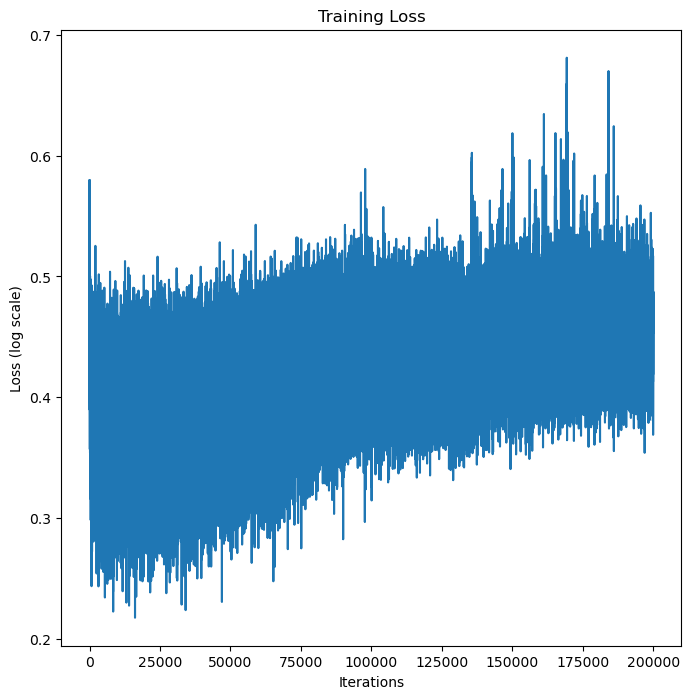

In [88]:
plt.figure(figsize=(8, 8))
plt.plot(lossi)
plt.xlabel('Iterations')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss')
plt.show();


In [89]:
with torch.no_grad():
    
    emb = C [Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    bnmean = hpreact.mean(0, keepdim = True)
    bnvar = hpreact.var(0, keepdim = True, unbiased = True)
    
    

In [91]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test' : (Xte, Yte),
        
    }[split]
    
    emb = C[x]
    embcat = emb.view (emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain  * (hpreact  - bnmean) * (bnvar + 1e-5)** -0.5 + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.819624185562134
val 2.8168625831604004


In [98]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    
    while True:
        
        emb = C[torch.tensor([context])] #forward pass
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5) ** -0.5 + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples =1 , generator = g).item()
        context = context[1:] + [ix] 
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))
    

ernaaimyaahreelmnd.
ryala.
etmrsjejdrleg.
adeeedieliihemy.
realeieiseananarneayzimhlkaa.
n.
sadbvrgahimies.
.
n.
jr.
eelklxnteuoanu.
a.
nedar.
yidle.
ehs.
laajaysknyaa.
hya.
nalyaisun.
zajelveuren.
.
